# Step 1 : Understanding the Data

## 📂 Data Loading & Exploration
- Load the training dataset (`train.csv`)  
- Check basic structure, missing values, and datatypes  
- Perform initial descriptive statistics to understand the feature distribution  


In [1]:
#Load and expolore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Loas train data
train=pd.read_csv("train.csv")

#Basic overview
print("Shape:", train.shape)
print("Columns:", train.columns.tolist())
print("\nData Types:\n", train.dtypes)
print("\nMissing Values:\n", train.isnull().sum())
print("\nSummary Stats:\n", train.describe(include="all").transpose())


Shape: (1200000, 21)
Columns: ['id', 'Age', 'Gender', 'Annual Income', 'Marital Status', 'Number of Dependents', 'Education Level', 'Occupation', 'Health Score', 'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type', 'Premium Amount']

Data Types:
 id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date        object
Customer Feedback        object
Smoking Status           object
Exercise Frequency       object


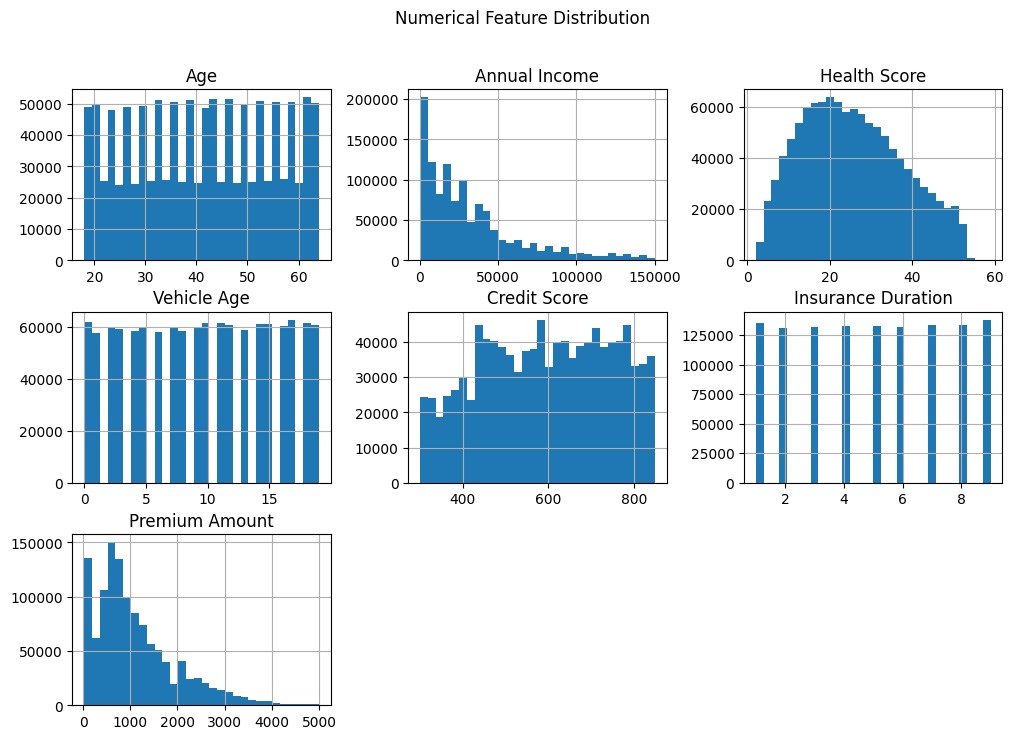

In [2]:
#Numerical Distributions
num_cols = ["Age", "Annual Income", "Health Score", 
            "Vehicle Age", "Credit Score", "Insurance Duration", 
            "Premium Amount"]

train[num_cols].hist(figsize=(12,8),bins=30)
plt.suptitle("Numerical Feature Distribution")
plt.show()                     


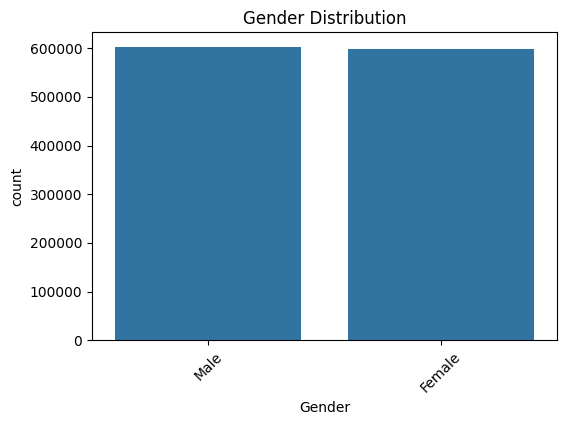

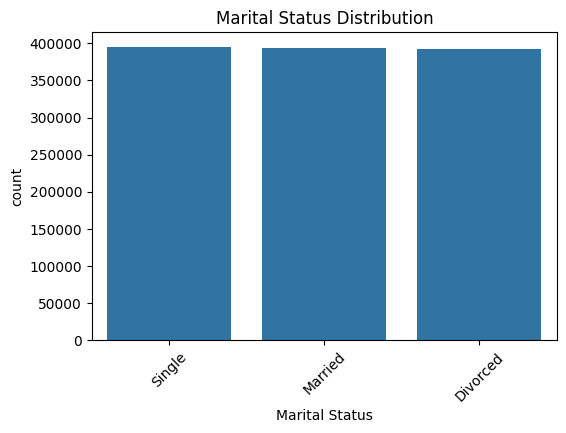

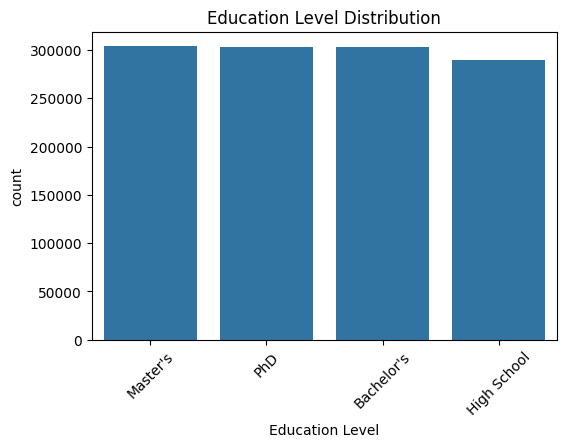

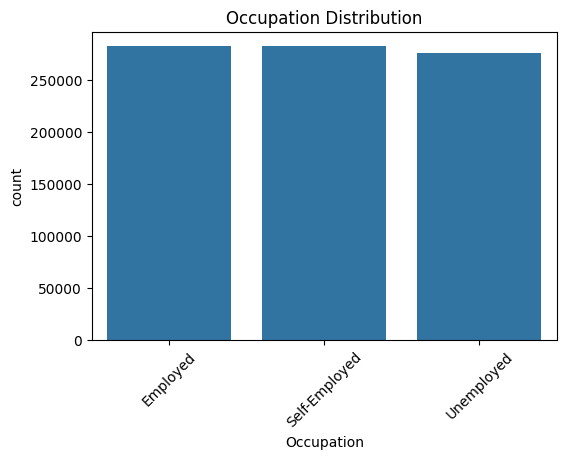

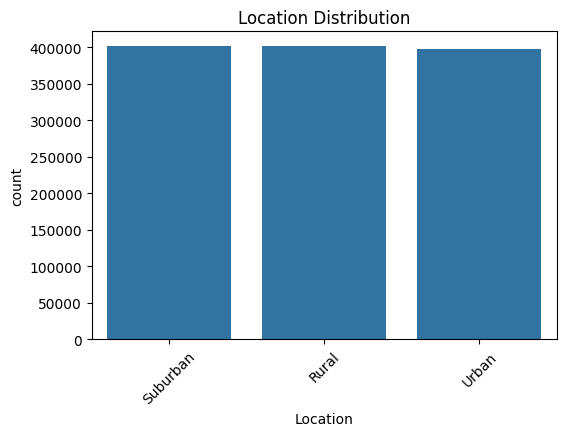

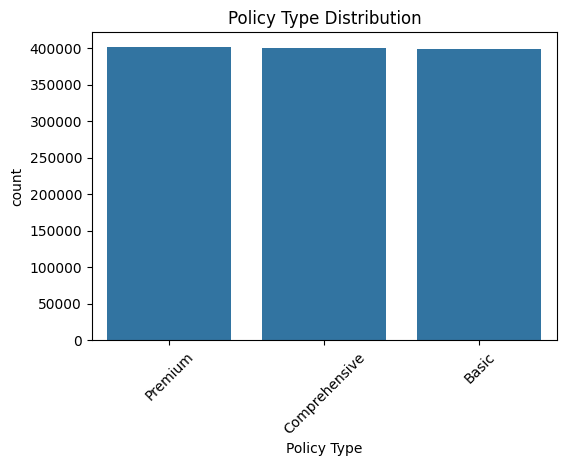

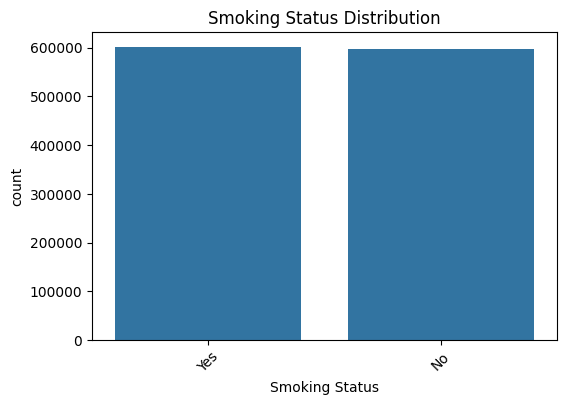

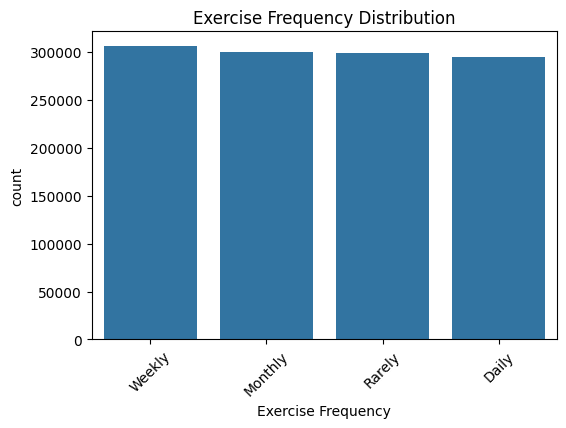

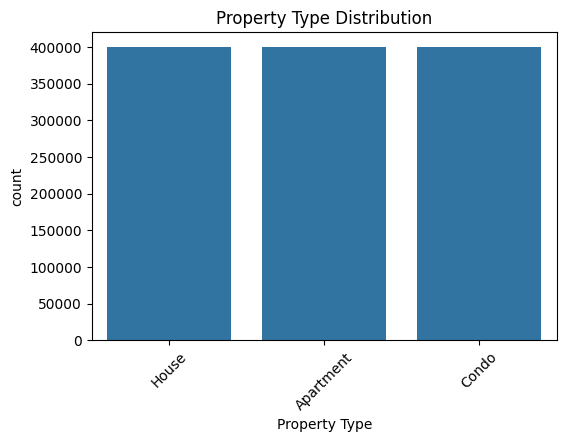

In [3]:
#Categorical coounts
cat_cols = ["Gender", "Marital Status", "Education Level", 
            "Occupation", "Location", "Policy Type", 
            "Smoking Status", "Exercise Frequency", "Property Type"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"{col} Distribution")
    plt.show()

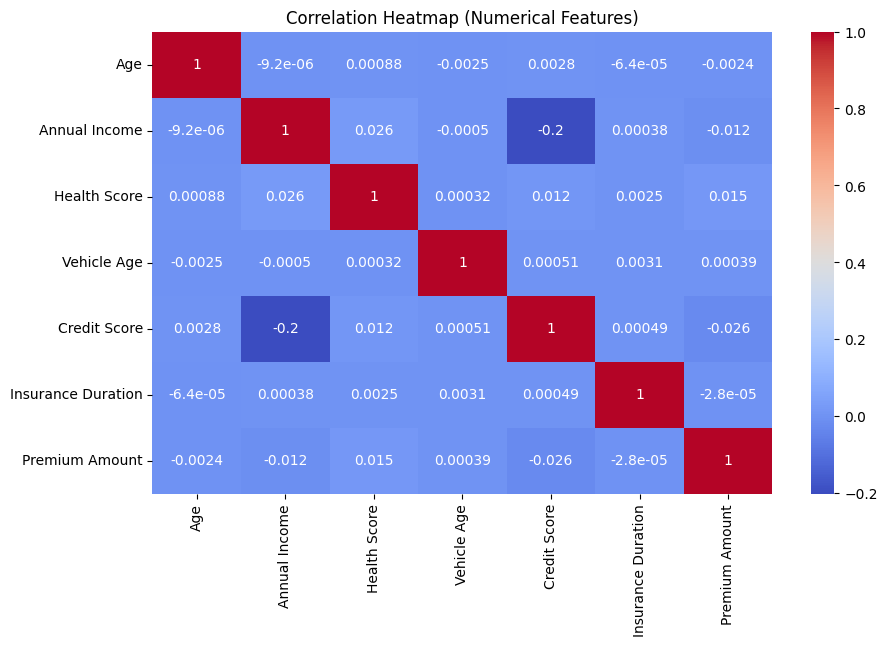

In [4]:
#Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# Step 2 : Data Preprocessing

## 🔧 Feature Engineering
- Apply custom transformations using `FeatureEngineer` class  
- Key steps:  
  - Outlier capping (`Previous Claims`)  
  - Log transformations (`Annual Income`, `Health Score`)  
  - Binning (`Income_Band`, `Health_Band`, `Credit_Band`)  
  - Age grouping (`Young`, `Mid`, `Mature`, `Senior`)  
  - Derived features (`Age_Smoking`, `VehiclePolicy`, `Duration_Category`, `Claims_per_Year`, `Property_Risk`)  
- Ensures consistency between training and inference  


In [5]:
#Data Preprocessing (with Feature Engineering Transformer)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#Custom Feature Engineering Transformer
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.risk_map = {"House": 3, "Condo": 2, "Apartment": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        #Outlier capping
        def cap_outliers(series, lower=0.01, upper=0.99):
            lower_bound = series.quantile(lower)
            upper_bound = series.quantile(upper)
            return np.clip(series, lower_bound, upper_bound)

        if "Previous Claims" in X.columns:
            X["Previous Claims"] = cap_outliers(X["Previous Claims"])

        #Log transforms
        for col in ["Annual Income", "Health Score"]:
            if col in X.columns:
                X[col] = np.log1p(X[col])

        #Feature Engineering
        if "Annual Income" in X.columns:
            X["Income_Band"] = pd.qcut(X["Annual Income"], q=5, labels=False, duplicates="drop")
        if "Health Score" in X.columns:
            X["Health_Band"] = pd.qcut(X["Health Score"], q=5, labels=False, duplicates="drop")
        if "Credit Score" in X.columns:
            X["Credit_Band"] = pd.qcut(X["Credit Score"], q=5, labels=False, duplicates="drop")

        if "Age" in X.columns:
            X["Age_Group"] = pd.cut(X["Age"], bins=[18, 30, 45, 60, 80],
                                    labels=["Young", "Mid", "Mature", "Senior"])
        if "Smoking Status" in X.columns and "Age" in X.columns:
            X["Age_Smoking"] = X["Age"] * (X["Smoking Status"] == "Yes").astype(int)

        if "Vehicle Age" in X.columns and "Policy Type" in X.columns:
            X["VehiclePolicy"] = X["Vehicle Age"].astype(str) + "_" + X["Policy Type"].astype(str)

        if "Insurance Duration" in X.columns:
            X["Duration_Category"] = pd.cut(
                X["Insurance Duration"],
                bins=[0, 2, 5, 10, 20],
                labels=["Short", "Mid", "Long", "Very Long"]
            )

        if "Previous Claims" in X.columns and "Insurance Duration" in X.columns:
            X["Claims_per_Year"] = X["Previous Claims"] / (X["Insurance Duration"] + 1)

        if "Property Type" in X.columns:
            X["Property_Risk"] = X["Property Type"].map(self.risk_map)

        return X

#Load and Prepare Data
df = train.copy()

#Convert Policy Start Date
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"], errors="coerce")
df["Policy_Start_Year"] = df["Policy Start Date"].dt.year
df["Policy_Start_Month"] = df["Policy Start Date"].dt.month
df = df.drop(columns=["Policy Start Date", "Customer Feedback", "id"], errors="ignore")

#Target log transform
df["Premium Amount"] = np.log1p(df["Premium Amount"])

#Feature / Target split
target = "Premium Amount"
X = df.drop(columns=[target])
y = df[target]

#Train-Test split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Preprocessing Pipeline
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

#Final Pipeline: Feature Engineering + Preprocessing
full_pipeline = Pipeline(steps=[
    ("features", FeatureEngineer()),
    ("preprocessor", preprocessor)
])

print("✅ Rebuilt preprocessing pipeline with feature engineering inside")
print("Train shape:", X_train.shape, "Validation shape:", X_valid.shape)


✅ Rebuilt preprocessing pipeline with feature engineering inside
Train shape: (960000, 19) Validation shape: (240000, 19)


# Step 3 : Model Development

## 🤖 Model Training
- Build pipeline with preprocessing and estimator  
- Train on training dataset  
- Select the best-performing model for evaluation  


In [7]:
#Quick Models (FAST Version)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

#Use a smaller sample for speed
X_train_sample = X_train.sample(frac=0.3, random_state=42)   # only 30% data
y_train_sample = y_train.loc[X_train_sample.index]
X_valid_sample = X_valid.sample(frac=0.3, random_state=42)
y_valid_sample = y_valid.loc[X_valid_sample.index]

print(f"⚡ Using sample: {X_train_sample.shape[0]} train rows, {X_valid_sample.shape[0]} valid rows")

⚡ Using sample: 288000 train rows, 72000 valid rows


## 📊 Model Evaluation
- Evaluate model performance using metrics:  
  - **RMSE (Root Mean Squared Error)** → measures prediction error magnitude  
  - **MAE (Mean Absolute Error)** → measures average absolute deviation  
  - **R² Score** → proportion of variance explained by the model  
- Compare results to identify overfitting/underfitting  


In [8]:
#Model Evaluation Function
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid):
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_valid)

    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    mae = mean_absolute_error(y_valid, preds)
    r2 = r2_score(y_valid, preds)

    print(f"\n📊 {name}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")

    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2, "Pipeline": pipe}

#Lightweight Models
models_quick = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=6, random_state=42),   # shallower
    "Random Forest (fast)": RandomForestRegressor(
        n_estimators=10, max_depth=8, random_state=42, n_jobs=-1),          # fewer trees
    "XGBoost (fast)": XGBRegressor(
        n_estimators=20, learning_rate=0.1, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, n_jobs=-1, tree_method="hist")
}

#Run Quick Models
results_quick = []
for name, model in models_quick.items():
    res = evaluate_model(name, model, X_train_sample, y_train_sample, X_valid_sample, y_valid_sample)
    results_quick.append(res)

#Results Summary
results_df = pd.DataFrame(results_quick).drop(columns=["Pipeline"])
print("\n📊 Quick Model Results (FAST Version)")
print(results_df)

best_model = min(results_quick, key=lambda x: x["RMSE"])
print("\n🏆 Best Quick Model:", best_model["Model"])


📊 Linear Regression
RMSE: 1.0913
MAE : 0.7937
R²  : 0.0127

📊 Decision Tree
RMSE: 1.0623
MAE : 0.7550
R²  : 0.0644

📊 Random Forest (fast)
RMSE: 1.0557
MAE : 0.7491
R²  : 0.0760

📊 XGBoost (fast)
RMSE: 1.0667
MAE : 0.7643
R²  : 0.0567

📊 Quick Model Results (FAST Version)
                  Model      RMSE       MAE        R2
0     Linear Regression  1.091294  0.793736  0.012700
1         Decision Tree  1.062309  0.754973  0.064449
2  Random Forest (fast)  1.055727  0.749124  0.076005
3        XGBoost (fast)  1.066720  0.764330  0.056663

🏆 Best Quick Model: Random Forest (fast)


In [9]:
#Full Model Training (XGBoost)
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#Define XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist",
    device="cpu"  
)

#Final pipeline (FeatureEngineer + Preprocessor + Model)
final_pipeline = Pipeline(steps=[
    ("features", FeatureEngineer()),   # feature engineering inside
    ("preprocessor", preprocessor),    # scaling + encoding
    ("model", xgb_model)               # regressor
])

#Train
final_pipeline.fit(X_train, y_train)

#Validation predictions
y_pred = final_pipeline.predict(X_valid)

#Metrics
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print("\n📊 XGBoost (Full Pipeline with Feature Engineering)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")



📊 XGBoost (Full Pipeline with Feature Engineering)
RMSE: 1.0543
MAE : 0.7489
R²  : 0.0754


# Step 4 : ML pipeline & MLFlow Integration

In [10]:
#MLflow Tracking + Save Best Model
import mlflow
import mlflow.sklearn
import joblib

mlflow.set_experiment("SmartPremium_Insurance_Costs")

with mlflow.start_run(run_name="XGBoost_FullPipeline"):
    #Log params
    mlflow.log_params({
        "model": "XGBoost",
        "n_estimators": 500,
        "learning_rate": 0.05,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8
    })
    
    #Log metrics
    mlflow.log_metrics({
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    })
    
    #Log model
    mlflow.sklearn.log_model(final_pipeline, artifact_path="model")
    
    print("\n📊 Final Model (Tracked in MLflow)")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

#Save locally for deployment
joblib.dump(final_pipeline, "best_model.pkl")
print("✅ Saved model as best_model.pkl")


2025/08/31 21:21:45 INFO mlflow.tracking.fluent: Experiment with name 'SmartPremium_Insurance_Costs' does not exist. Creating a new experiment.
2025/08/31 21:21:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/31 21:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



📊 Final Model (Tracked in MLflow)
RMSE: 1.0543, MAE: 0.7489, R²: 0.0754
✅ Saved model as best_model.pkl
